In [1]:
%matplotlib inline

In [2]:
from pathlib import Path

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [4]:
def train(model, device, loader, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        y_pred = output.argmax(dim=1, keepdim=True)
        correct += y_pred.eq(y.view_as(y_pred)).sum().item()
    return {
        "loss": total_loss / len(loader.dataset),
        "accuracy": correct / len(loader.dataset),
    }


In [5]:
def test(model, device, loader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            total_loss += F.nll_loss(output, y, reduction='sum').item()
            y_pred = output.argmax(dim=1, keepdim=True)
            correct += y_pred.eq(y.view_as(y_pred)).sum().item()
    return {
        "loss": total_loss / len(loader.dataset),
        "accuracy": correct / len(loader.dataset),
    }

In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
preprocess_x = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.1307, ), (0.3081, )),
])
additional_args = {"num_workers": 1, "pin_memory": True, } if use_cuda else {}

In [7]:
data_path = Path("data")
path = data_path / "mnist"
train_ds = datasets.MNIST(path, train=True, download=True, transform=preprocess_x)
test_ds = datasets.MNIST(path, train=False, transform=preprocess_x)

train_loader = torch.utils.data.DataLoader(train_ds,
    batch_size=64, shuffle=True, **additional_args
)
test_loader = torch.utils.data.DataLoader(test_ds,
    batch_size=1000, shuffle=False, **additional_args
)

In [8]:
model = Net().to(device)

optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)

In [9]:
with tqdm(range(1, 16)) as progress:
  for epoch in progress:
    result = train(model, device, train_loader, optimizer)
    scheduler.step()
    progress.write(str(result))
    
result = test(model, device, test_loader)
print(str(result))
torch.save(model.state_dict(), data_path / "mnist_cnn.pt")

  7%|▋         | 1/15 [02:30<35:03, 150.27s/it]

{'loss': 0.003268834636399212, 'accuracy': 0.9372333333333334}


 13%|█▎        | 2/15 [05:00<32:31, 150.11s/it]

{'loss': 0.0012699502895547389, 'accuracy': 0.9760166666666666}


 20%|██        | 3/15 [07:29<29:59, 150.00s/it]

{'loss': 0.0008958357824924557, 'accuracy': 0.9836}


 27%|██▋       | 4/15 [10:00<27:31, 150.11s/it]

{'loss': 0.0007421607226036334, 'accuracy': 0.9860166666666667}


 33%|███▎      | 5/15 [12:29<24:57, 149.75s/it]

{'loss': 0.0006262910722526915, 'accuracy': 0.9885}


 40%|████      | 6/15 [14:57<22:24, 149.34s/it]

{'loss': 0.0005668199750956168, 'accuracy': 0.98985}


 47%|████▋     | 7/15 [17:25<19:52, 149.10s/it]

{'loss': 0.0005300429137064688, 'accuracy': 0.9900666666666667}


 53%|█████▎    | 8/15 [19:54<17:23, 149.01s/it]

{'loss': 0.0005185782718372745, 'accuracy': 0.9906666666666667}


 60%|██████    | 9/15 [22:23<14:53, 148.97s/it]

{'loss': 0.0005121911351234303, 'accuracy': 0.9908333333333333}


 67%|██████▋   | 10/15 [24:52<12:24, 148.80s/it]

{'loss': 0.00047798625561711863, 'accuracy': 0.9910833333333333}


 73%|███████▎  | 11/15 [27:21<09:55, 148.91s/it]

{'loss': 0.0004665923051480301, 'accuracy': 0.9914}


 80%|████████  | 12/15 [29:51<07:28, 149.47s/it]

{'loss': 0.00044888686068516107, 'accuracy': 0.9917833333333334}


 87%|████████▋ | 13/15 [32:21<04:59, 149.53s/it]

{'loss': 0.00045188078460475176, 'accuracy': 0.9918166666666667}


 93%|█████████▎| 14/15 [34:50<02:29, 149.36s/it]

{'loss': 0.00045257163435041245, 'accuracy': 0.99165}


100%|██████████| 15/15 [37:19<00:00, 149.33s/it]


{'loss': 0.0004407294024271929, 'accuracy': 0.9918}
{'loss': 0.027240875059366225, 'accuracy': 0.9909}


In [10]:
pred = []
Y = []
model = model.eval()
for i, (x,y) in enumerate(test_loader):
    x = x.to(device)
    with torch.no_grad():
        output = model(x)
    pred += [int(l.argmax()) for l in output]
    Y += [int(l) for l in y]
print(classification_report(Y, pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



予測結果は7
この画像データの正解ラベルは7です


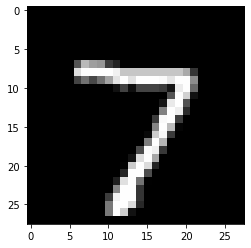

In [13]:
index = 0
x, y = iter(test_loader).__next__()
data = x.to(device)
output = model(data)
pred = output.argmax(dim=1, keepdim=True)
print("予測結果は{}".format(pred[index].item()))

show = x[index].numpy()
plt.imshow(show.reshape(28, 28), cmap="gray")
print("この画像データの正解ラベルは{:.0f}です".format(y[index]))

予測結果は7
この画像データの正解ラベルは7です


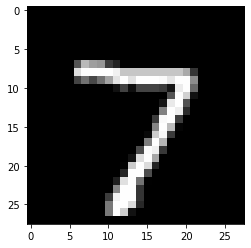

In [14]:
index = 0
x, y = test_ds[index]
x = x.view(-1, 1, 28, 28)
data = x.to(device)
output = model(data)
pred = output.argmax(dim=1, keepdim=True)
print("予測結果は{}".format(pred.item()))

show = x.numpy()
plt.imshow(show.reshape(28, 28), cmap="gray")
print("この画像データの正解ラベルは{:.0f}です".format(y))